# EE 344 — Assignment 5: Power-System Fault Classification with Deep Neural Networks

In this assignment, you will predict **power-system fault conditions** from 6 input measurements using **PyTorch**.
There are many ways to implement DNNs for prediction tasks; here you will implement and compare **three** common setups.

**Dataset**: `classData.csv`

**Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`  
**Outputs**: 4-bit label `[G, C, B, A]`

Dataset (Kaggle): https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification

**Note:** Do **NOT** download the dataset from Kaggle. Use the dataset file provided on Canvas with this assignment.

Your tasks:
1. **Part 1** — Regression-style DNN to predict 4 outputs (then round to bits).
2. **Part 2** — Multi-label DNN to predict 4 bits (sigmoid / BCE-style loss).
3. **Part 3** — Multi-class DNN to predict no fault and 5 fault types (softmax / cross-entropy).
4. **Part 4** — Brief discussion: which approach is best and why.
5. **Part 5** — Open-ended: build a **binary** classifier (Fault vs No Fault) using the best approach.


## Setup
Run the next cell to import libraries and define helper functions.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def plot_cm(cm, title, labels):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def bit_reports(Y_true_bits, Y_pred_bits, split_name='Test', bit_names=('G','C','B','A')):
    """Multi-label report + per-bit 2x2 confusion matrices."""
    print(f"\n=== Bit-level Report | {split_name} ===")
    print(classification_report(Y_true_bits, Y_pred_bits, target_names=list(bit_names), digits=4))
    for j, lab in enumerate(bit_names):
        cm = confusion_matrix(Y_true_bits[:, j], Y_pred_bits[:, j], labels=[0, 1])
        print(f"\nBit {lab} | {split_name} CM (rows=true 0/1, cols=pred 0/1):\n{cm}")


Device: cuda


## Dataset

The file `classData.csv` contains a dataset for classifying fault conditions.

- **Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`
- **Outputs**: `[G, C, B, A]`

Examples:
- `[0 0 0 0]` — No Fault
- `[1 0 0 1]` — LG fault (Phase A to ground)
- `[0 0 1 1]` — LL fault (Phase A to Phase B)
- `[1 0 1 1]` — LLG fault (Phases A,B to ground)
- `[0 1 1 1]` — LLL fault (all three phases)
- `[1 1 1 1]` — LLLG fault (three phases + ground)


In [43]:
# ----------------------------
# Load data + create targets
# ----------------------------
CSV_PATH = 'classData.csv'
df = pd.read_csv(CSV_PATH)

label_cols = ['G','C','B','A']
feature_cols = ['Ia','Ib','Ic','Va','Vb','Vc']

missing = [c for c in (label_cols + feature_cols) if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}. Found: {list(df.columns)}")

X = df[feature_cols].astype(np.float32).values            # (N,6)
Y_bits = df[label_cols].astype(int).values                # (N,4)

FAULT_NAMES = ['No Fault','LG','LL','LLG','LLL','LLLG']

def bits_to_fault_type_idx(bits_gcba):
    G, C, B, A = map(int, bits_gcba)
    n_phase = C + B + A
    if G == 0 and n_phase == 0: return 0
    if G == 1 and n_phase == 1: return 1
    if G == 0 and n_phase == 2: return 2
    if G == 1 and n_phase == 2: return 3
    if G == 0 and n_phase == 3: return 4
    if G == 1 and n_phase == 3: return 5
    raise ValueError(f"Unexpected pattern [G,C,B,A]={bits_gcba}")

y_fault = np.array([bits_to_fault_type_idx(row) for row in Y_bits], dtype=int)
print('Fault counts:', dict(zip(FAULT_NAMES, np.bincount(y_fault, minlength=len(FAULT_NAMES)))))

# One shared split (recommended for fair comparison across Parts 1–3)
X_train, X_test, Y_train, Y_test, y_fault_train, y_fault_test = train_test_split(
    X, Y_bits, y_fault, test_size=0.30, random_state=RANDOM_STATE, stratify=y_fault
)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])


Fault counts: {'No Fault': np.int64(2365), 'LG': np.int64(1129), 'LL': np.int64(1004), 'LLG': np.int64(1134), 'LLL': np.int64(1096), 'LLLG': np.int64(1133)}
Train size: 5502 | Test size: 2359


## Part 1 — DNN Model 1 (Regression-style 4-output model)

You will build a DNN that outputs **4 real-valued numbers** and train it with **MSE**.
During evaluation, you will **round** predictions to the nearest integer, clamp to `{0,1}`, and then compare against the true 4-bit label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 (linear)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**


In [44]:
# ----------------------------
# Part 1: Robust scaling (fit on train only)
# ----------------------------
scaler_1 = RobustScaler()
X_train_s1 = scaler_1.fit_transform(X_train).astype(np.float32)
X_test_s1  = scaler_1.transform(X_test).astype(np.float32)

# Torch datasets
Xtr = torch.from_numpy(X_train_s1)
Xte = torch.from_numpy(X_test_s1)
Ytr = torch.from_numpy(Y_train.astype(np.float32))
Yte = torch.from_numpy(Y_test.astype(np.float32))

BATCH_SIZE = 256
train_loader_1 = DataLoader(TensorDataset(Xtr, Ytr), batch_size=BATCH_SIZE, shuffle=True)

# Hyperparameters
INPUT_DIM = 6
H1 = 16
H2 = 8
OUT_DIM = 4
DROPOUT_P = 0.25
L2_WEIGHT_DECAY = 1e-4
LR = 1e-3
EPOCHS = 1000


In [45]:
## [ TODO 1 ]
# Define the DNN for Part 1 using PyTorch.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: linear (no activation)
# - Use BatchNorm and Dropout in hidden layers
#
# Write your model class below.

class DNN_Reg4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1), # <-- hidden layer (weights + bias)
            nn.BatchNorm1d(h1), # <-- batch norm (stability/regularization)
            nn.ReLU(), # <-- nonlinearity
            nn.Dropout(p_drop), # <-- dropout regularization
            nn.Linear(h1, h2), # <-- hidden layer (weights + bias)
            nn.BatchNorm1d(h2), # <-- batch norm (stability/regularization)
            nn.ReLU(), # <-- nonlinearity
            nn.Dropout(p_drop), # <-- dropout regularization
            nn.Linear(h2, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [46]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: MSE
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...

# model = DNN_Reg4(...).to(device)
model = DNN_Reg4(input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)


In [47]:
# ----------------------------
# Training loop (you fill the key missing pieces)
# ----------------------------
## [ TODO 3 ]
def train_part1(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            # TODO: forward pass
            # TODO: compute loss
            # TODO: backward
            # TODO: optimizer step
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            print(f"Epoch {ep:3d} | train MSE (scaled y): {total/n:.6f}")

@torch.no_grad()
def predict_part1(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    out = model(X_t).cpu().numpy()  # (N,4) real-valued
    return out

# TODO: Train the model
train_part1(model, train_loader_1, epochs=EPOCHS)


Epoch   1 | train MSE (scaled y): 0.774280
Epoch 500 | train MSE (scaled y): 0.101504
Epoch 1000 | train MSE (scaled y): 0.100770


In [48]:
# ----------------------------
# Evaluation (round -> clamp to {0,1} -> report)
# ----------------------------
yhat_train = predict_part1(model, X_train_s1)
yhat_test  = predict_part1(model, X_test_s1)

# After you obtain yhat_* (shape N x 4):
pred_bits_train = np.clip(np.rint(yhat_train).astype(int), 0, 1)
pred_bits_test  = np.clip(np.rint(yhat_test ).astype(int), 0, 1)
bit_reports(Y_train, pred_bits_train, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.8730    0.7955    0.8325      2377
           C     0.9947    0.9205    0.9562      2263
           B     0.9975    0.9300    0.9626      3057
           A     0.9760    0.9714    0.9737      3144

   micro avg     0.9641    0.9105    0.9365     10841
   macro avg     0.9603    0.9043    0.9312     10841
weighted avg     0.9634    0.9105    0.9359     10841
 samples avg     0.6613    0.6425    0.6468     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2850  275]
 [ 486 1891]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3228   11]
 [ 180 2083]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2438    7]
 [ 214 2843]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2283   75]
 [  90 3054]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.8592    0.8027    0.8300      1019
           C     0.9890    

d:\Miniconda\Miniconda\envs\audio-ml\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Miniconda\Miniconda\envs\audio-ml\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Miniconda\Miniconda\envs\audio-ml\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sha

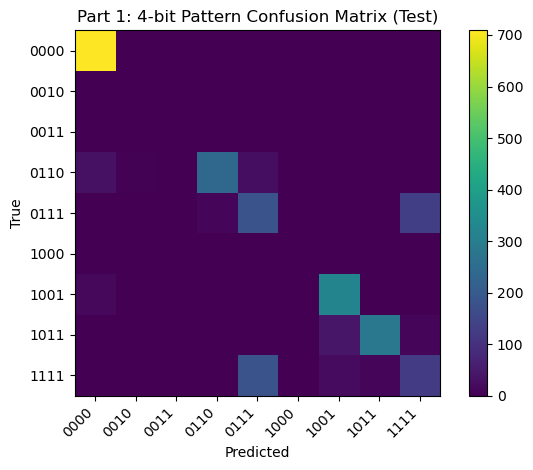

[[709   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 33   5   0 238  25   0   0   0   0]
 [  0   2   0  12 182   0   0   2 131]
 [  0   0   0   0   0   0   0   0   0]
 [ 16   0   0   0   0   2 320   1   0]
 [  0   1   2   0   0   0  43 284  10]
 [  0   0   0   1 181   0  21  12 125]]


: 

In [ ]:
# One confusion matrix over full 4-bit patterns (for TEST set)
true_str = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str = [''.join(map(str, r.tolist())) for r in pred_bits_test]
labels = sorted(list(set(true_str) | set(pred_str)))
cm = confusion_matrix(true_str, pred_str, labels=labels)
plot_cm(cm, 'Part 1: 4-bit Pattern Confusion Matrix (Test)', labels)
print(cm)

## Part 2 — DNN Model 2 (Multi-label 4-bit classification)

You will build a DNN that predicts the 4 bits `[G, C, B, A]` as a **multi-label** output.
Each output dimension is an independent binary label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 logits (apply sigmoid only for evaluation)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use a **binary cross-entropy style loss on logits** (do not apply sigmoid inside the model).


In [28]:
# ----------------------------
# Part 2: Robust scaling (fit on train only)
# ----------------------------
scaler_2 = RobustScaler()
X_train_s2 = scaler_2.fit_transform(X_train).astype(np.float32)
X_test_s2  = scaler_2.transform(X_test).astype(np.float32)

Xtr2 = torch.from_numpy(X_train_s2)
Xte2 = torch.from_numpy(X_test_s2)
Ytr2 = torch.from_numpy(Y_train.astype(np.float32))
Yte2 = torch.from_numpy(Y_test.astype(np.float32))

train_loader_2 = DataLoader(TensorDataset(Xtr2, Ytr2), batch_size=BATCH_SIZE, shuffle=True)


In [29]:
## [ TODO 1 ]
# Define the DNN for Part 2.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: 4 logits (no sigmoid inside the model)
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiLabel4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1), # <-- hidden layer (weights + bias)
            nn.BatchNorm1d(h1), # <-- batch norm (stability/regularization)
            nn.ReLU(), # <-- nonlinearity
            nn.Dropout(p_drop), # <-- dropout regularization
            nn.Linear(h1, h2), # <-- hidden layer (weights + bias)
            nn.BatchNorm1d(h2), # <-- batch norm (stability/regularization)
            nn.ReLU(), # <-- nonlinearity
            nn.Dropout(p_drop), # <-- dropout regularization
            nn.Linear(h2, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [30]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: binary cross-entropy style loss on logits -- BCEWithLogitsLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...
model_2 = DNN_MultiLabel4(input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P).to(device)
loss_fn_2 = nn.BCEWithLogitsLoss()
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)



In [ ]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3]
def train_part2(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            # TODO: logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            # TODO: backward + step

            # total += loss.item() * xb.size(0)
            optimizer_2.zero_grad()
            logits = model(xb)
            loss = loss_fn_2(logits, yb)
            loss.backward()
            optimizer_2.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            print(f"Epoch {ep:3d} | train Binary Cross Entropy Loss: {total/n:.6f}")

@torch.no_grad()
def predict_bits_part2(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    pred_bits = (probs >= threshold).astype(int)
    return pred_bits

# TODO: Train the model
train_part2(model_2, train_loader_2, epochs=EPOCHS)


Epoch   1 | train Cross Entropy Loss: 0.753327
Epoch 500 | train Cross Entropy Loss: 0.226093
Epoch 1000 | train Cross Entropy Loss: 0.222378


In [34]:
# ----------------------------
# Evaluation
# ----------------------------
pred_bits_train_ = predict_bits_part2(model_2, X_train_s2)
pred_bits_test_  = predict_bits_part2(model_2, X_test_s2)

bit_reports(Y_train, pred_bits_train_, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test_,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.7740    0.9680    0.8602      2377
           C     1.0000    0.8975    0.9460      2263
           B     0.9499    0.9745    0.9621      3057
           A     0.9783    0.9873    0.9827      3144

   micro avg     0.9206    0.9607    0.9402     10841
   macro avg     0.9255    0.9568    0.9377     10841
weighted avg     0.9300    0.9607    0.9424     10841
 samples avg     0.6415    0.6719    0.6520     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2453  672]
 [  76 2301]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3239    0]
 [ 232 2031]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2288  157]
 [  78 2979]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2289   69]
 [  40 3104]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.7683    0.9666    0.8561      1019
           C     1.0000    

d:\Miniconda\Miniconda\envs\audio-ml\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Miniconda\Miniconda\envs\audio-ml\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Miniconda\Miniconda\envs\audio-ml\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sha

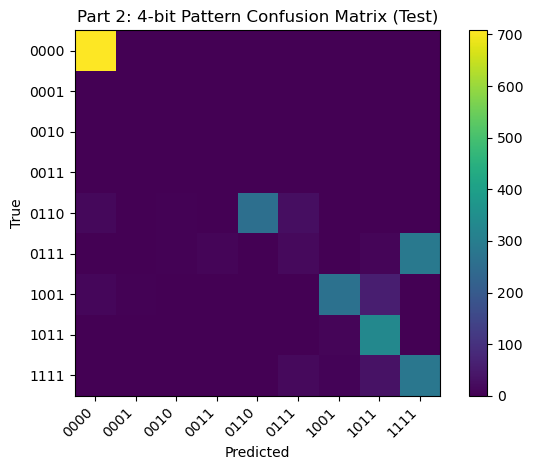

[[708   1   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 14   0   4   0 258  25   0   0   0]
 [  0   0   3  11   0  19   0  11 285]
 [ 12   5   0   0   0   0 263  59   0]
 [  0   0   0   0   0   0   9 331   0]
 [  0   0   0   0   0  17   8  34 281]]


In [35]:
# One confusion matrix over full 4-bit patterns (For TEST set)
true_str_ = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str_ = [''.join(map(str, r.tolist())) for r in pred_bits_test_]
labels_ = sorted(list(set(true_str_) | set(pred_str_)))
cm_ = confusion_matrix(true_str_, pred_str_, labels=labels_)
plot_cm(cm_, 'Part 2: 4-bit Pattern Confusion Matrix (Test)', labels_)
print(cm_)

## Part 3 — DNN Model 3 (Multi-class fault type classification)

In this part, you will predict one of **6 fault types**.
The 4-bit label is converted to a single class in `{0,1,2,3,4,5}` using the provided mapping.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 6 logits
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use **cross-entropy loss** for multi-class classification.


In [36]:
# ----------------------------
# Part 3: Robust scaling (fit on train only)
# ----------------------------
scaler_3 = RobustScaler()
X_train_s3 = scaler_3.fit_transform(X_train).astype(np.float32)
X_test_s3  = scaler_3.transform(X_test).astype(np.float32)

ytr3 = torch.from_numpy(y_fault_train.astype(np.int64))
yte3 = torch.from_numpy(y_fault_test.astype(np.int64))
Xtr3 = torch.from_numpy(X_train_s3)
Xte3 = torch.from_numpy(X_test_s3)

train_loader_3 = DataLoader(TensorDataset(Xtr3, ytr3), batch_size=BATCH_SIZE, shuffle=True)


In [37]:
## [ TODO 1 ]
# Define the DNN for Part 3.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 6
# - Hidden activations: ReLU
# - Output: 6 logits
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiClass6(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, num_classes=6, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1), # <-- hidden layer (weights + bias)
            nn.BatchNorm1d(h1), # <-- batch norm (stability/regularization)
            nn.ReLU(), # <-- nonlinearity
            nn.Dropout(p_drop), # <-- dropout regularization
            nn.Linear(h1, h2), # <-- hidden layer (weights + bias)
            nn.BatchNorm1d(h2), # <-- batch norm (stability/regularization)
            nn.ReLU(), # <-- nonlinearity
            nn.Dropout(p_drop), # <-- dropout regularization
            nn.Linear(h2, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [38]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: CrossEntropyLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...

model_3 = DNN_MultiClass6(input_dim=INPUT_DIM, h1=H1, h2=H2, num_classes=6, p_drop=DROPOUT_P).to(device)
loss_fn_3 = nn.CrossEntropyLoss()
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)


In [39]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3 ]
def train_part3(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            # TODO: logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            # TODO: backward + step

            # total += loss.item() * xb.size(0)

            optimizer_3.zero_grad()
            logits = model(xb)
            loss = loss_fn_3(logits, yb)
            loss.backward()
            optimizer_3.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            print(f"Epoch {ep:3d} | train Cross Entropy Loss: {total/n:.6f}")

@torch.no_grad()
def predict_part3(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    return torch.argmax(logits, dim=1).cpu().numpy()

# TODO: Train the model
train_part3(model_3, train_loader_3, epochs=EPOCHS)


Epoch   1 | train Cross Entropy Loss: 1.832267
Epoch 500 | train Cross Entropy Loss: 0.647053
Epoch 1000 | train Cross Entropy Loss: 0.626321



=== Part 3 | Train ===
              precision    recall  f1-score   support

    No Fault     0.9617    1.0000    0.9805      1655
          LG     0.9036    0.9494    0.9259       790
          LL     1.0000    0.9132    0.9546       703
         LLG     0.9352    0.9446    0.9398       794
         LLL     0.5325    0.3742    0.4395       767
        LLLG     0.4824    0.5889    0.5304       793

    accuracy                         0.8272      5502
   macro avg     0.8026    0.7950    0.7951      5502
weighted avg     0.8255    0.8272    0.8232      5502



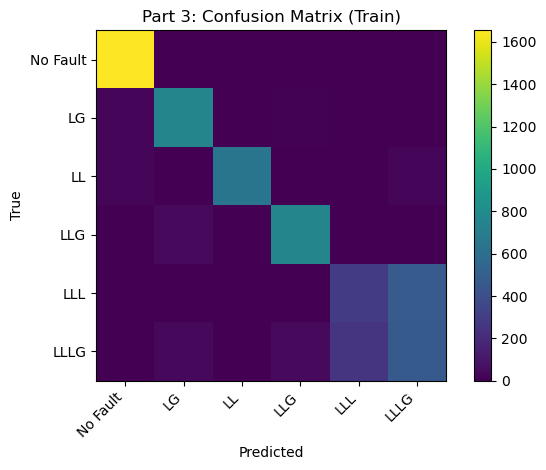


=== Part 3 | Test ===
              precision    recall  f1-score   support

    No Fault     0.9595    1.0000    0.9793       710
          LG     0.9195    0.9440    0.9316       339
          LL     1.0000    0.9103    0.9530       301
         LLG     0.9474    0.9529    0.9501       340
         LLL     0.5398    0.3708    0.4396       329
        LLLG     0.4942    0.6235    0.5514       340

    accuracy                         0.8317      2359
   macro avg     0.8101    0.8003    0.8008      2359
weighted avg     0.8316    0.8317    0.8280      2359



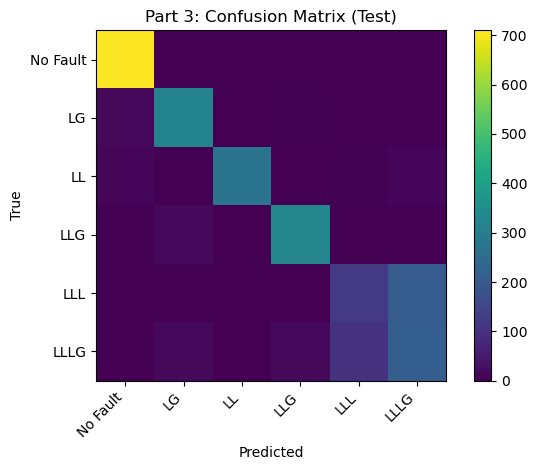

In [40]:
# ----------------------------
# Evaluation
# ----------------------------
pred_train = predict_part3(model_3, X_train_s3)
pred_test  = predict_part3(model_3, X_test_s3)

print('\n=== Part 3 | Train ===')
print(classification_report(y_fault_train, pred_train, target_names=FAULT_NAMES, digits=4))
cm_tr = confusion_matrix(y_fault_train, pred_train, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_tr, 'Part 3: Confusion Matrix (Train)', FAULT_NAMES)

print('\n=== Part 3 | Test ===')
print(classification_report(y_fault_test, pred_test, target_names=FAULT_NAMES, digits=4))
cm_te = confusion_matrix(y_fault_test, pred_test, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_te, 'Part 3: Confusion Matrix (Test)', FAULT_NAMES)


## Part 4 — Discussion

Answer **2–5 sentences** for each prompt.

1. Compare Parts 1–3. Which formulation fits this dataset best (regression-style, multi-label, or multi-class), and why?

2. When you used the bit-based approaches (Part 1 and Part 2), did you observe any **inconsistent 4-bit outputs** (invalid fault patterns)? What does that suggest?

3. Looking at confusion matrices, which fault types (or bit positions) were the hardest to predict? Give one plausible reason.

### Your answers
- Q1: The multi-label fits this dataset slightly better than regression-style. The multi-class doesn't perform as good as the former two. Multi-label formulation fits the dataset the best as it has the highest macro recall and F-1 score despite its lower precision compared to regression-style formulation.
- Q2: Yes, the pattern 0110 is invalid. It suggests hidden dependency between output categories that was learned by the model.
- Q3: LLL and LLLG fault types, specifically distinguishing between 0111 and 1111 has the highest confusion. A possible reason is that the features for these two faults are very similar in the dataset.


## Part 5 — Open-ended extension: Binary classification (Fault vs No Fault)

In this part, you will create a **binary** classification problem:

- Class 0: **No Fault** (`[0,0,0,0]`)
- Class 1: **Fault** (any other pattern)

**Your task**: Using the best formulation you identified in Part 4, build a DNN to classify **Fault vs No Fault**.

Requirements:
- Use a **70% / 30%** train/test split (stratified)
- Use **RobustScaler** (fit on train only)
- Report **classification report** and **confusion matrix** on **train and test**

Implementation notes:
- First create a dataset with two classes by compressing all fault types into a single “Fault” class (and keeping “No Fault” as the other class).
- Keep your solution clean and focused: data, model, training, evaluation.


In [3]:
# ----------------------------
# Load data + create targets
# ----------------------------
CSV_PATH = 'classData.csv'
df = pd.read_csv(CSV_PATH)

label_cols = ['G','C','B','A']
feature_cols = ['Ia','Ib','Ic','Va','Vb','Vc']

missing = [c for c in (label_cols + feature_cols) if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}. Found: {list(df.columns)}")

X = df[feature_cols].astype(np.float32).values            # (N,6)
Y_bits = df[label_cols].astype(int).values                # (N,4)

FAULT_NAMES = ['No Fault','LG','LL','LLG','LLL','LLLG']

def bits_to_fault_type_idx(bits_gcba):
    G, C, B, A = map(int, bits_gcba)
    n_phase = C + B + A
    if G == 0 and n_phase == 0: return 0
    if G == 1 and n_phase == 1: return 1
    if G == 0 and n_phase == 2: return 2
    if G == 1 and n_phase == 2: return 3
    if G == 0 and n_phase == 3: return 4
    if G == 1 and n_phase == 3: return 5
    raise ValueError(f"Unexpected pattern [G,C,B,A]={bits_gcba}")

y_fault = np.array([bits_to_fault_type_idx(row) for row in Y_bits], dtype=int)

y_fault = (y_fault != 0).astype(int)
FAULT_NAMES = ['No Fault', 'Fault']
print('Fault counts:', dict(zip(FAULT_NAMES, np.bincount(y_fault, minlength=len(FAULT_NAMES)))))

# One shared split (recommended for fair comparison across Parts 1–3)
X_train, X_test, Y_train, Y_test, y_fault_train, y_fault_test = train_test_split(
    X, Y_bits, y_fault, test_size=0.30, random_state=RANDOM_STATE, stratify=y_fault
)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])

Fault counts: {'No Fault': np.int64(2365), 'Fault': np.int64(5496)}
Train size: 5502 | Test size: 2359


In [9]:
# ----------------------------
# Part 2: Robust scaling (fit on train only)
# ----------------------------
scaler_5 = RobustScaler()
X_train_s5 = scaler_5.fit_transform(X_train).astype(np.float32)
X_test_s5  = scaler_5.transform(X_test).astype(np.float32)

Xtr5 = torch.from_numpy(X_train_s5)
Xte5 = torch.from_numpy(X_test_s5)
Ytr5 = torch.from_numpy(Y_train.astype(np.float32))
Yte5 = torch.from_numpy(Y_test.astype(np.float32))

BATCH_SIZE = 256
train_loader_5 = DataLoader(TensorDataset(Xtr5, Ytr5), batch_size=BATCH_SIZE, shuffle=True)

# Hyperparameters
INPUT_DIM = 6
H1 = 16
H2 = 8
OUT_DIM = 1
DROPOUT_P = 0.25
L2_WEIGHT_DECAY = 1e-4
LR = 1e-3
EPOCHS = 1000


In [10]:
class DNN_MultiLabel2(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1), # <-- hidden layer (weights + bias)
            nn.BatchNorm1d(h1), # <-- batch norm (stability/regularization)
            nn.ReLU(), # <-- nonlinearity
            nn.Dropout(p_drop), # <-- dropout regularization
            nn.Linear(h1, h2), # <-- hidden layer (weights + bias)
            nn.BatchNorm1d(h2), # <-- batch norm (stability/regularization)
            nn.ReLU(), # <-- nonlinearity
            nn.Dropout(p_drop), # <-- dropout regularization
            nn.Linear(h2, out_dim)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
model_5 = DNN_MultiLabel2(input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P).to(device)
loss_fn_5 = nn.BCEWithLogitsLoss()
optimizer_5 = torch.optim.Adam(model_5.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)

In [12]:
def train_part5(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            yb = (yb.sum(dim=1) != 0).float().unsqueeze(1)

            # TODO: zero gradients
            # TODO: logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            # TODO: backward + step

            # total += loss.item() * xb.size(0)
            optimizer_5.zero_grad()
            logits = model(xb)
            loss = loss_fn_5(logits, yb)
            loss.backward()
            optimizer_5.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            print(f"Epoch {ep:3d} | train Binary Cross Entropy Loss: {total/n:.6f}")

@torch.no_grad()
def predict_bits_part5(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    pred_bits = (probs >= threshold).astype(int)
    return pred_bits

# TODO: Train the model
train_part5(model_5, train_loader_5, epochs=EPOCHS)

Epoch   1 | train Cross Entropy Loss: 0.620753
Epoch 500 | train Cross Entropy Loss: 0.056821
Epoch 1000 | train Cross Entropy Loss: 0.052046


In [ ]:

def bit_reports(Y_true_bits, Y_pred_bits, split_name='Test', bit_names=('No Fault','Fault')):
    Y_true_bits = np.asarray(Y_true_bits)
    Y_pred_bits = np.asarray(Y_pred_bits)

    # true: (N,4) -> (N,) binary; otherwise flatten
    if Y_true_bits.ndim == 2 and Y_true_bits.shape[1] == 4:
        y_true = (Y_true_bits.sum(axis=1) != 0).astype(int)
    else:
        y_true = Y_true_bits.reshape(-1).astype(int)

    # pred: (N,1) -> (N,)
    y_pred = Y_pred_bits.reshape(-1).astype(int)

    print(f"\n=== Binary Report | {split_name} ===")
    print(classification_report(y_true, y_pred, target_names=list(bit_names), digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print(f"\n{split_name} Confusion Matrix (rows=true 0/1, cols=pred 0/1):\n{cm}")

In [21]:
# ----------------------------
# Evaluation
# ----------------------------
pred_bits_train_ = predict_bits_part5(model_5, X_train_s5)
pred_bits_test_  = predict_bits_part5(model_5, X_test_s5)

bit_reports(Y_train, pred_bits_train_, split_name='Train')
bit_reports(Y_test,  pred_bits_test_,  split_name='Test')


=== Binary Report | Train ===
              precision    recall  f1-score   support

    No Fault     0.9650    0.9994    0.9819      1655
       Fault     0.9997    0.9844    0.9920      3847

    accuracy                         0.9889      5502
   macro avg     0.9824    0.9919    0.9870      5502
weighted avg     0.9893    0.9889    0.9890      5502


Train Confusion Matrix (rows=true 0/1, cols=pred 0/1):
[[1654    1]
 [  60 3787]]

=== Binary Report | Test ===
              precision    recall  f1-score   support

    No Fault     0.9713    1.0000    0.9854       710
       Fault     1.0000    0.9873    0.9936      1649

    accuracy                         0.9911      2359
   macro avg     0.9856    0.9936    0.9895      2359
weighted avg     0.9914    0.9911    0.9911      2359


Test Confusion Matrix (rows=true 0/1, cols=pred 0/1):
[[ 710    0]
 [  21 1628]]


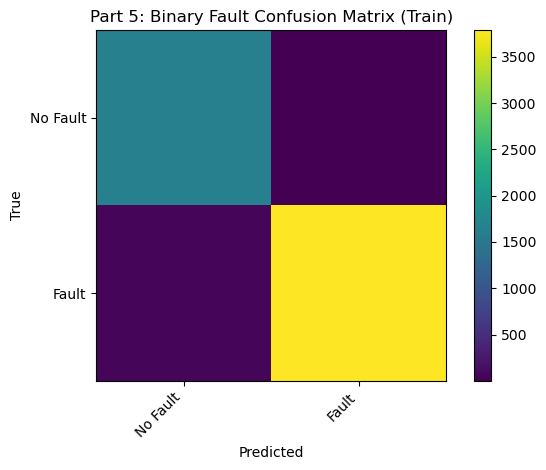

[[1654    1]
 [  60 3787]]


In [ ]:
true_bin_ = (Y_train.sum(axis=1) != 0).astype(int)
pred_bin_ = pred_bits_train_.reshape(-1)
labels_ = ['No Fault', 'Fault']
cm_ = confusion_matrix(true_bin_, pred_bin_, labels=[0, 1])
plot_cm(cm_, 'Part 5: Binary Fault Confusion Matrix (Train)', labels_)
print(cm_)

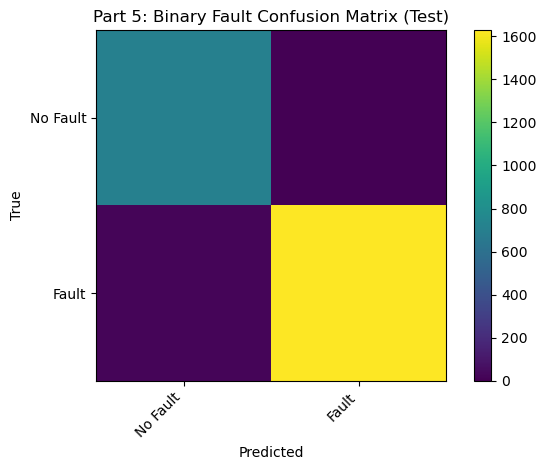

[[ 710    0]
 [  21 1628]]


In [ ]:
true_bin_ = (Y_test.sum(axis=1) != 0).astype(int)
pred_bin_ = pred_bits_test_.reshape(-1)
labels_ = ['No Fault', 'Fault']
cm_ = confusion_matrix(true_bin_, pred_bin_, labels=[0, 1])
plot_cm(cm_, 'Part 5: Binary Fault Confusion Matrix (Test)', labels_)
print(cm_)